<a href="https://colab.research.google.com/github/sp8rks/MaterialsInformatics/blob/main/worked_examples/CNNs/CNNSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Segmentation

In this notebook we will build a CNN segmentation model using the U-Net architecture. The goal will be to be able to pass it images of dendrite growth and successfully generate a mask that can segment it out from the image. 

## What Are CNNs?
Convolutional Neural Networks (CNNs) have become an essential model in modern computer vision. Unlike traditional methods that rely on handcrafted features, CNNs learn these features directly through a series of convolutional layers. Often CNNs are used for image classification, however, they can also help segment out objects. They essentially assign classify the pixels in the image by assigning it a label to form a cohesive mask. We will use a CNN within the U-Net framework to perform the segmentation task. 

## What is U-Net?

U-Net is a type of CNN that was originally designed for biomedical imagery segmentation but has been adapted to broader uses. The U-Net consists of two parts: the encoder and decoder. The encoder compresses the input by reducing resolution and increasing feature depth while the decoder reconstructs the image through a series of resampling steps. 

Video: https://www.youtube.com/watch?v=K3LsUl04Oa4

Reference: https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/


## Setup

To start we will import our libraries. Similar to the GANs notebook, we will be using the torch neural network base model as well as importing our data from Foundry. 

In [ ]:
#install libraries
!pip install scikit-learn
!pip install foundry_ml
!pip install scikit-image
!pip install tensorflow
!pip install keras-unet
!pip install opencv-python

In [134]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from foundry.foundry import Foundry
import numpy as np
import torchvision
import cv2
import torch.utils.data as data
import torchvision.transforms as transforms


Next we will import the dendrite images from Foundry. After importing them, we will import them into the X and y variables. The X variable will contain the original images of the dendritic growth while the y variable will contain the matching masks. These masks are used as training input to the model.

In [135]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

f = Foundry(use_globus=False)

datasets = f.search("foundry_stan_segmentation_v1.1")

dataset = datasets.get_dataset_by_name("foundry_stan_segmentation_v1.1")

res = dataset.get_as_dict()
X = res['train']['input']['train/input']
y = res['train']['target']['train/output']

Before we move on from loading the data we need to do the first steps of preprocessing the data. The first is to resize it to something that works better with U-Net such as 32. This is because a lot of the downsampling and upsampling deal with powers of 2 and so a multiple of 32 is convenient for that. Next we need to make sure the channel, height, and width channels are in the right place. Because we are using cv2, we need to make sure of this before we do anything else. cv2 imports the images as (H, W, C) where PyTorch needs the images to be (C, H, W). Furthermore, cv2 imports the images as BGR rather than RGB. 

In [136]:
new_size = 32 * 10  # U-Net requires a multiple of 32

# Convert BGR to RGB while resizing the images
X_r = np.array([cv2.cvtColor(cv2.resize(img, dsize=(new_size, new_size)), cv2.COLOR_BGR2RGB)
                for img in X])

y_r = np.array([cv2.resize(mask, dsize=(new_size, new_size)) for mask in y])

# Ensure images are converted to [C, H, W] format for PyTorch
X_r = np.array([img.transpose(2, 0, 1) for img in X_r])  # From [H, W, C] to [C, H, W]


## Preprocessing the Images

### Transformations

This class transforms the images by converting them to tensors. Furthermore, it makes sure that the masks are binary for use with the U-Net model. 

In [137]:

class DendriteDataset(data.Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        # Normalize images to range [0, 1] and convert to tensors
        if self.transform:
            image = self.transform(image)
        
        # Convert masks to tensors, but keep as binary masks (0, 1)
        mask = torch.Tensor(mask).unsqueeze(0)  # Add channel dimension to mask (shape: [1, H, W])
        
        return image, mask

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts image to PyTorch tensor (automatically scales to [0, 1])
])

# Create dataset and dataloaders
train_dataset = DendriteDataset(X_r, y_r)
train_loader = data.DataLoader(train_dataset, batch_size=8, shuffle=True)

### Visualizing the Images

It's always important to look at what you are passing into your model. In this case, we can display a few dendrite images and their associated masks.

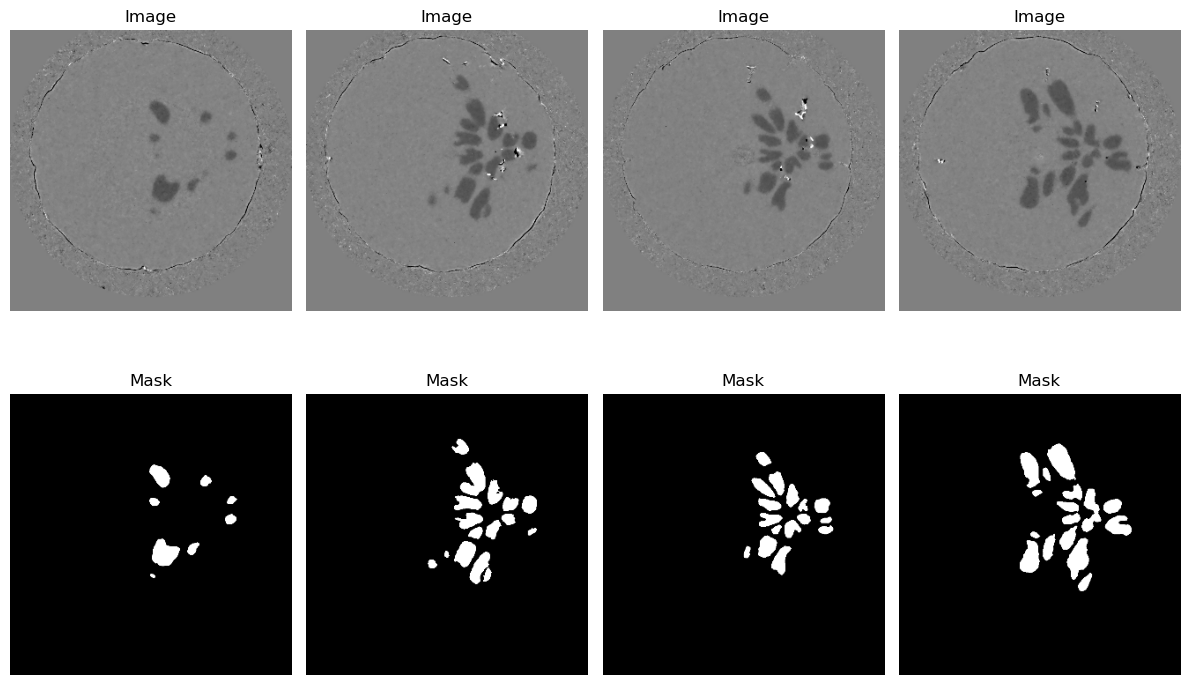

In [138]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images and masks from the dataloader
images, masks = next(iter(train_loader))

# Convert images and masks to numpy for visualization
images_np = images.permute(0, 2, 3, 1).cpu().numpy()  # Convert to (batch_size, H, W, C)
masks_np = masks.squeeze(1).cpu().numpy()  # Convert to (batch_size, H, W)

# Plot the first few images and masks
plt.figure(figsize=(12, 8))

for i in range(4):  # Display first 4 images and masks
    plt.subplot(2, 4, i+1)
    plt.imshow(images_np[i])  # Show the image
    plt.title('Image')
    plt.axis('off')
    
    plt.subplot(2, 4, i+5)
    plt.imshow(masks_np[i], cmap='gray')  # Show the corresponding mask
    plt.title('Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()

## The Layers

### Block
We will now define the layers that will be used in our UNet model. Because the UNet consists of repeating "blocks" of sublayers, it's advantageous to condense them into a single class for ease of use later. This class inherits from the PyTorch neural network module which is the base class for neural network layers. 

- in_ch defines the number of channels that are being passed through the model. In the case of this notebook, we are passing 3 channels through (RGB)

- out_ch defines the number of channels that will be in the outputted data. In the case of this notebook, we are keeping it at the same 3 (RGB)

The block of layers consists of a convolutional layer, a ReLU layer, and another convolutional layer. 

- Conv2d is the first convolutional layer. The convolution uses the same in_ch and out_ch defined above. The arguments kernel_size and padding define what kernel is being used for the convolution steps. For this convolutional layer the kernel is a 3x3 and has 1 padding which ensures that the dimensionality stays the same. This is important to have as it prevents the need for dimensional tracking throughout U-Net. The second convolutional layer is the same as the first except that it uses the out_ch as the input channel and output channel which lets it keep the depth of the feature map the same. 

- ReLU is an activation function applied after each convolution in order to introduce non-linearity into the model. This sets all of the negative values in the input to zero while keeping positive values the same. This assists the model in being able to see more complex patterns. 

In [139]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)  # Add padding to maintain size
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)  # Add padding to maintain size
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        return self.relu(self.conv2(x))

### The Encoder

Similar to the other U-Net classes, the encoder block inherits the neural network base module from PyTorch. It uses the block class defined earlier to perform its encoding. 

- chs controls how many channels at each level of the encoder. As the input moves deeper into the model the channels increase. These channels represent the depth of the feature map. 
- enc_blocks takes the block class that we defined earlier and runs it for each increase in channels (with each passthrough outputting the increased number of channels). The input number of channels is chs[i] and the outputted number of channels is chs[i+1]
- The ModuleList creates a neural-network specific list of the feature maps in each step of the encoding.
- pool reduces the spatial dimension by a factor of 2. It takes the maximum value of each 2x2 block to do so. After each convolution block the size is halved which performs the downsampling. 
- ftrs is the list that will store the feature maps. These maps will be used in the future by the encoder. 

The input "x" is passed through the block layer. After each block x is updated with the output of the block. Each block applies two convolutional layers followed by a ReLU. The output of each block(x) is then stored in the ftrs list. Finally, pool(x) applies max-pooling to reduce the spatial dimension by half. The output of the encoder is the sequential list of feature maps (ftrs). 

In [140]:
class Encoder(nn.Module):
    def __init__(self, chs=(3,64,128,256,512)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs
    


### The Decoder

The decoder performs the upsampling process used in the U-Net architecture. It upsamples the feature maps to create the final image. The decoder progressively upsamples the input feature maps (from the encoder) and refines them to create a segmentation map the same spatial size as the original image. 

- chs controls the channels at each level of the decoder. These should **always** be the reverse of the encoder. As seen below the channels start at 512 (the highest channel of the encoder) and work their way back to 64. The reason it does not return to 3 channels (from the original image) is because its creating the segmentation masks with multiple channels. 
- upconvs is a list of ConvTranspose2d layers which upsample the feature maps. The kernel size of 2 and stride of 2 effectively doubles the feature map size with every iteration thus undoing the halving operations performed by the encoder. 
- dec_blocks is a list of block layers which increases the spatial dimension further 
- crop ensures the encoder feature maps and the decoder feature maps have the same number of spatial dimensions for concatination 

The decoder first starts by passing the input "x" through the transposed convolution layers to upsample it. The corresponding feature map from the encoder is cropped to match the spatial size of the upsampled feature map of x which ensures they can be concatenated. The upsampled feature map is then concatenated with the cropped feature map of the encoder. This allows the U-Net model to combine high-resolution, low-level features from the encoder with the upsampled, high-level features from the decoder. The concatenated feature map is then passed through the convolutional block which refines the feature maps once more. 


In [141]:
class Decoder(nn.Module):
    def __init__(self, chs=(512, 256, 128, 64)):
        super().__init__()
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], kernel_size=2, stride=2) 
                                         for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 

    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs
        
    def forward(self, x, encoder_features):
        for i in range(len(self.upconvs)):
            x = self.upconvs[i](x)  # Upsample the feature maps
            enc_ftrs = self.crop(encoder_features[i], x)  # Crop encoder features to match size
            x = torch.cat([x, enc_ftrs], dim=1)  # Concatenate encoder features with upsampled features
            x = self.dec_blocks[i](x)  # Pass through the block
        return x
    

    


### The U-Net

- enc_chs controls the number of channels at each stage of the encoder
- dec_chs controls the number of channels at each stage of the decoder
- head is the final 1x1 convolution layer maps the output of the decoder to the desire number of channels
- num_class is how many segmentations that are desired for the model to find. In this case we are looking for a single mask

To pass the image through the U-Net the model first passes it into the encoder function. The encoder returns a list of feature maps which are progressively downsampled with each step. The model then passes the feature maps into the decoder. The feature maps from the encoder maps are reversed to match the reversed order of the channels. The final convolution maps the output to the desired channels. Because we are segmenting a single thing it will end up as a single channel. 

In [142]:
class UNet(nn.Module):
    def __init__(self, enc_chs=(3,64,128,256,512), dec_chs=(512,256,128,64), num_class=1):
        super().__init__()
        self.encoder = Encoder(enc_chs)
        self.decoder = Decoder(dec_chs)
        self.head    = nn.Conv2d(dec_chs[-1], num_class, kernel_size=1)  # Final 1x1 conv for binary classification
    
    def forward(self, x):
        enc_ftrs = self.encoder(x)  # Encode the input image
        x = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])  # Decode and upsample, concatenating with encoder features
        x = self.head(x)  # Final 1x1 convolution to get predictions
        
        return x

## Training the Model

First we initialize the model (UNet), the loss function (Binary Cross Entropy with Logits), and the optmizer (Adam Optimizer).

- Binary Cross Entropy with Logits loss function is used because it is specifically designs for binary classification tasks which is perfect for our task. It combines a sigmoid activation with the binary cross-entropy loss which numerically stabilizes it

- Adam optimizer updates the model parameters based on the gradients computed through backpropagation

- num_epochs controls how many cycles of the training loop the script will run

model.train() sets the model to training mode which is what we want for this loop. The epoch_loss parameter collects the total loss for the training cycle. 

The loop iterates over each batch of images and masks from the train_loader variable defined earlier. The dataloader breaks the dataset into smaller batches. 

In the forward pass the input images are passed through the U-Net model and the predicted masks are returned as logits (raw predictions). The loss is then computed with the BCEWithLogitsLoss loss function. This loss measures how close the predicted masks are to the ground truth which is the premade masks we intially had. The model then clears the gradients (a good idea when using PyTorch and computing new gradients) and backpropagates the loss to find the loss gradient. The adam optimizer then updates the parameters of the model using the calculated gradient. 

- loss.item converts the loss value into a float which can be added to the epoch_loss variable to track the total loss for the epoch

In [143]:
# Initialize model, loss function, and optimizer
model = UNet().to(device)
criterion = nn.BCEWithLogitsLoss()  # For binary segmentation, use BCEWithLogitsLoss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        
        # Forward pass
        preds = model(images)
        masks = masks[..., 0]  # Reduces the shape from (8, 1, 320, 320, 3) to (8, 1, 320, 320)

        # Compute loss
        loss = criterion(preds, masks)  # Use first channel of mask
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader)}')

Epoch 1/10, Loss: 0.6158433556556702
Epoch 2/10, Loss: 0.3712954558432102
Epoch 3/10, Loss: 0.1754138246178627
Epoch 4/10, Loss: 0.17843016609549522
Epoch 5/10, Loss: 0.1583449374884367
Epoch 6/10, Loss: 0.147958192974329
Epoch 7/10, Loss: 0.14760098978877068
Epoch 8/10, Loss: 0.13633286766707897
Epoch 9/10, Loss: 0.13281359151005745
Epoch 10/10, Loss: 0.12099097482860088


## Visualization of the Results

Lastly, we can visualize the predicted masks generated by the model. As you can see, the masks are a little worse than the original masks but still pretty good. 

In [144]:
def plot_results(original_image, true_mask, predicted_mask, overlayed_mask):
    """Function to plot the original image, true mask, predicted mask, and overlayed mask."""
    fig, axs = plt.subplots(1, 4, figsize=(16, 6))
    
    # Original Image
    axs[0].imshow(original_image)
    axs[0].set_title('Original Image')
    axs[0].axis('off')
    
    # True Mask
    axs[1].imshow(true_mask, cmap='gray')
    axs[1].set_title('Training Mask')
    axs[1].axis('off')
    
    # Predicted Mask
    axs[2].imshow(predicted_mask, cmap='gray')
    axs[2].set_title('Predicted Mask')
    axs[2].axis('off')
    
    # Overlayed Mask on Original Image
    axs[3].imshow(overlayed_mask)
    axs[3].set_title('Overlayed Mask')
    axs[3].axis('off')
    
    plt.tight_layout()
    plt.show()

### Predicted Masks and Visualization

First, the model is set to the evaluation mode. The gradient calculation is turned off with torch.no_grad() as we are not training the model at this point. The masks are then predicted and displayed over the original images in red. 

Input Image Shape: torch.Size([8, 3, 320, 320])
Predicted Mask Shape: torch.Size([8, 1, 320, 320])


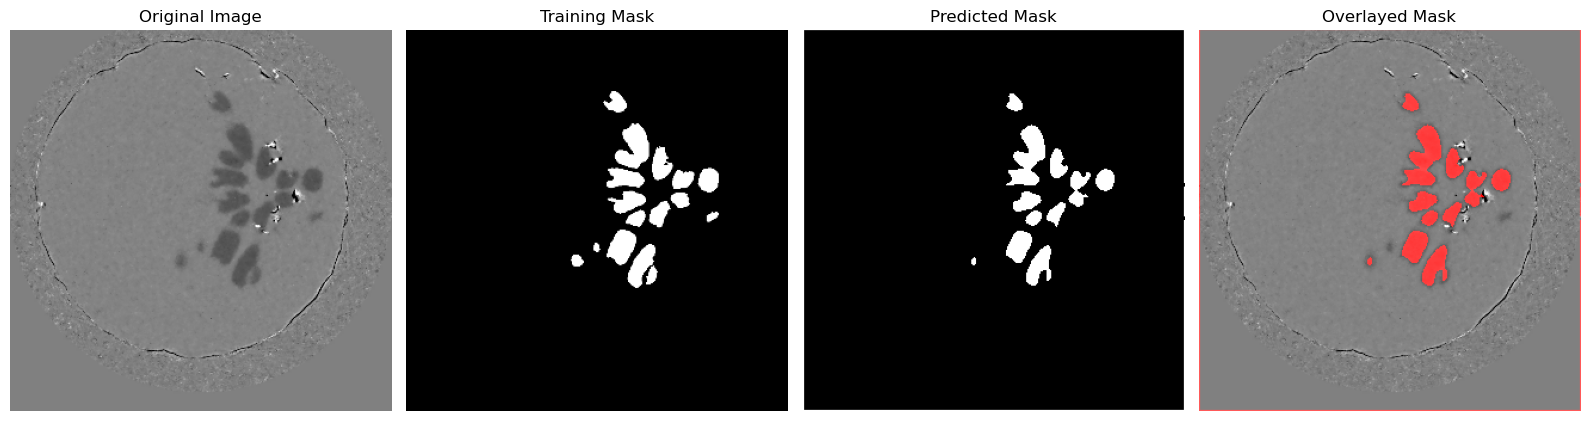

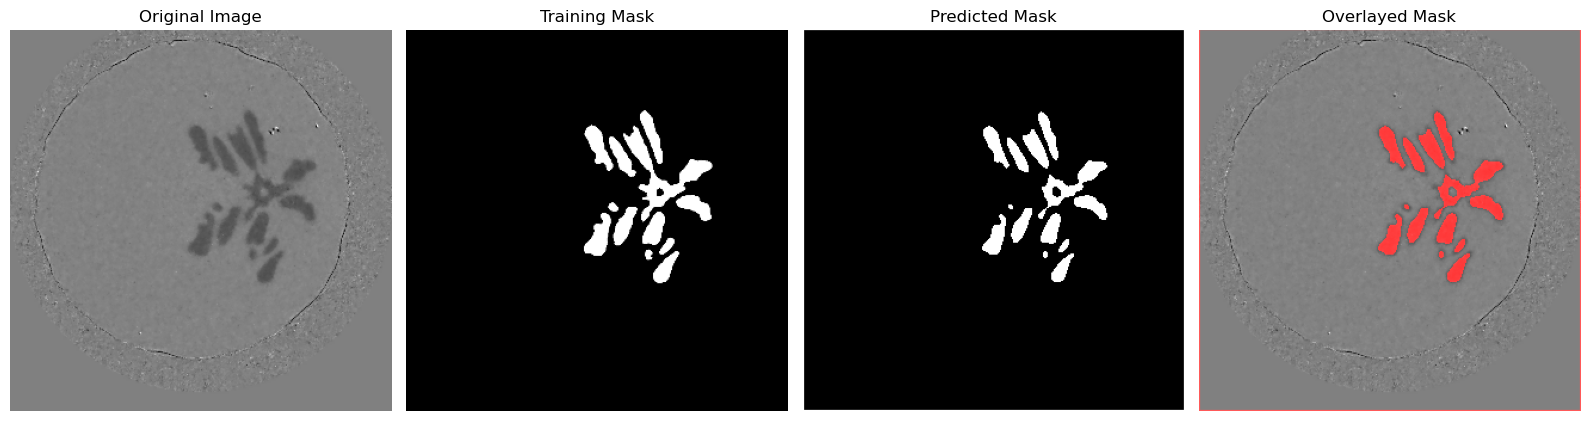

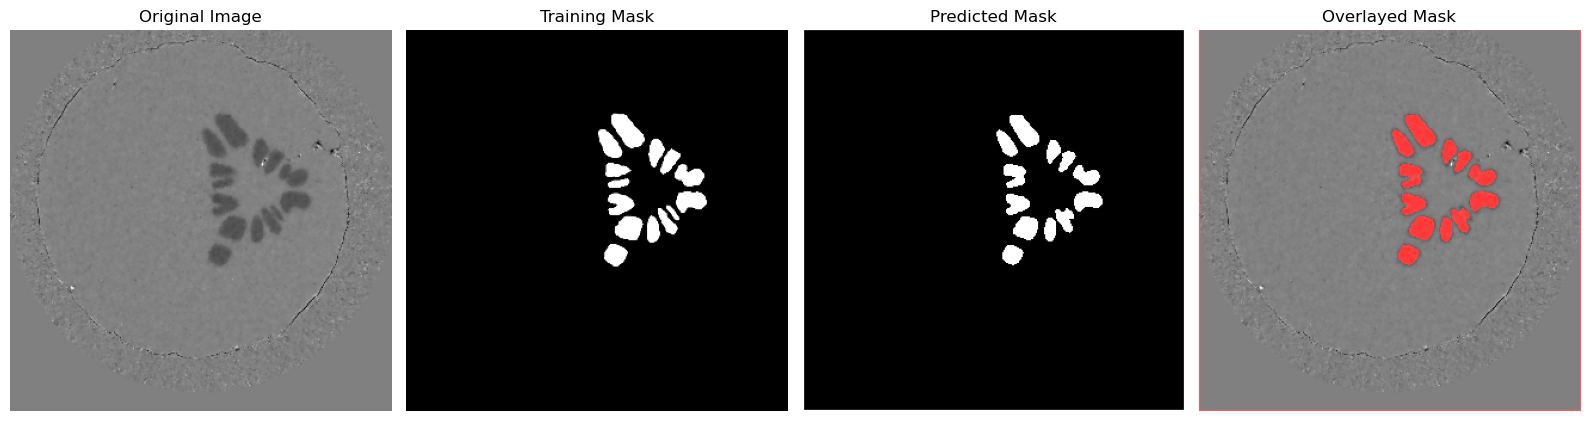

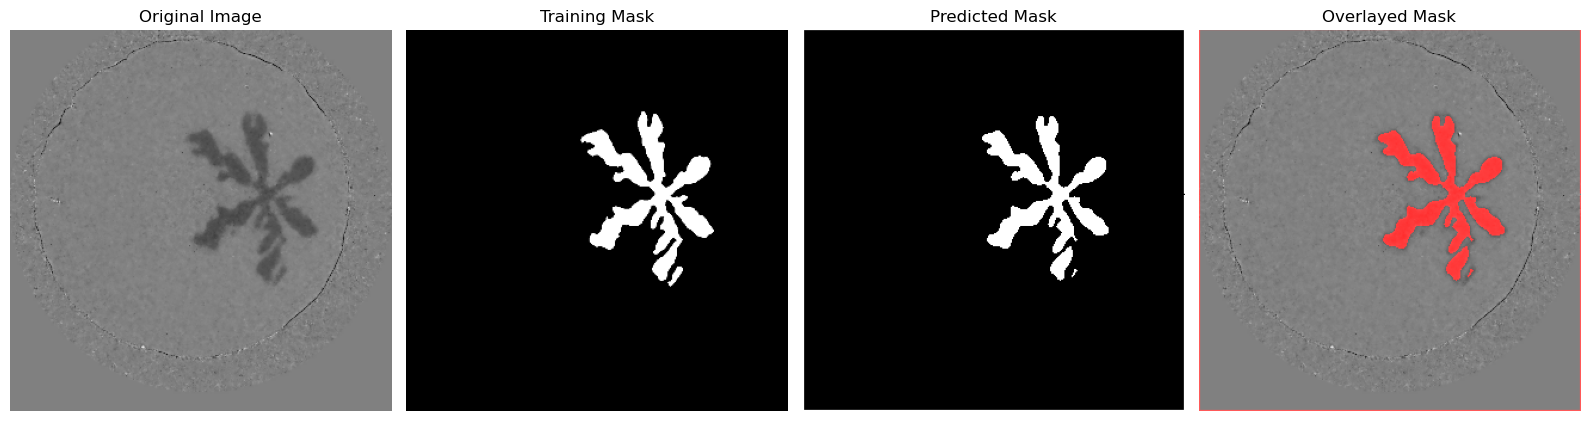

In [145]:
# Inference on a batch of images from the test set
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No need to compute gradients during inference
    images, masks = next(iter(train_loader))  # Get a batch of images and masks
    images, masks = images.to(device), masks.to(device)
    
    # Get model predictions
    preds = model(images)
    
    # Print shapes to verify
    print(f'Input Image Shape: {images.shape}')  # Should be (batch_size, 3, H, W)
    print(f'Predicted Mask Shape: {preds.shape}')  # Should be (batch_size, 1, H, W)

    # Apply sigmoid to convert logits to probabilities in [0, 1]
    preds = torch.sigmoid(preds)
    
    # Apply threshold to convert probabilities to binary masks
    preds = (preds > 0.1).float()  # Threshold predictions to binary
    
    # Convert predictions, images, and masks to NumPy arrays for visualization
    images_np = images.permute(0, 2, 3, 1).cpu().numpy()  # Convert images to (batch_size, H, W, C)
    masks_np = masks.squeeze(1).cpu().numpy()  # Convert masks to (batch_size, H, W)
    preds_np = preds.squeeze(1).cpu().numpy()  # Convert predictions to (batch_size, H, W)

    # Loop through the batch and visualize the results
    for i in range(4):  # Visualize the first 4 images and masks
        original_image = images_np[i]
        true_mask = masks_np[i]
        predicted_mask = preds_np[i]

        # Threshold the predicted mask to make it binary (0 or 1)
        predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8)

        # Create an empty RGB mask with only the red channel
        predicted_mask_rgb = np.zeros_like(original_image)  # (H, W, 3)
        predicted_mask_rgb[:, :, 0] = predicted_mask_binary * 255  # Apply the mask to the red channel only (index 0)

        # Convert original image from RGB to BGR (OpenCV format)
        original_image_bgr = cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR)

        # Overlay the red mask on the original image using cv2.addWeighted
        overlayed_mask = original_image_bgr.copy()
        overlayed_mask[predicted_mask_binary == 1] = cv2.addWeighted(
            original_image_bgr[predicted_mask_binary == 1], 0.7, 
            predicted_mask_rgb[predicted_mask_binary == 1], 0.3, 0
        )

        # Plot the original image, training mask, predicted mask, and overlayed mask
        plot_results(original_image, true_mask, predicted_mask_binary, overlayed_mask)

